### Import Libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load and Explore Your Dataset

In [22]:
df = pd.read_csv('D:\\Decryptogen\\dataset\\personality_dataset.csv')
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
print(df.info())
print("\nFirst 10 rows:")
print(df.head(10))
print("\nMissing values:")
print(df.isnull().sum())
print("\nTarget distribution:")
print(df['Personality'].value_counts())

Dataset shape: (2900, 8)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None

First 10 rows:
   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         No                      4.0            6.0   
1               9.0        Yes                      0.0            0.0 

### Data Preprocessing

In [23]:
print("\n=== Data Preprocessing ===")

# Handle missing values
print("Handling missing values...")
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Filled missing values in {col} with median: {df[col].median()}")
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"Filled missing values in {col} with mode: {df[col].mode()[0]}")

# Convert categorical variables
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from categorical columns if present
if 'Personality' in categorical_cols:
    categorical_cols.remove('Personality')

print(f"Categorical columns to encode: {categorical_cols}")

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col} mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Encode target variable
target_encoder = LabelEncoder()
df['Personality_encoded'] = target_encoder.fit_transform(df['Personality'])
print(f"Target mapping: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

print("\nData after preprocessing:")
print(df.head())
print(f"\nFinal dataset shape: {df.shape}")


=== Data Preprocessing ===
Handling missing values...
Filled missing values in Time_spent_Alone with median: 4.0
Filled missing values in Stage_fear with mode: No
Filled missing values in Social_event_attendance with median: 3.0
Filled missing values in Going_outside with median: 3.0
Filled missing values in Drained_after_socializing with mode: No
Filled missing values in Friends_circle_size with median: 5.0
Filled missing values in Post_frequency with median: 3.0
Categorical columns to encode: ['Stage_fear', 'Drained_after_socializing']
Stage_fear mapping: {'No': 0, 'Yes': 1}
Drained_after_socializing mapping: {'No': 0, 'Yes': 1}
Target mapping: {'Extrovert': 0, 'Introvert': 1}

Data after preprocessing:
   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0           0                      4.0            6.0   
1               9.0           1                      0.0            0.0   
2               9.0           1                      1.0   

### Exploratory Data Analysis


=== Exploratory Data Analysis ===


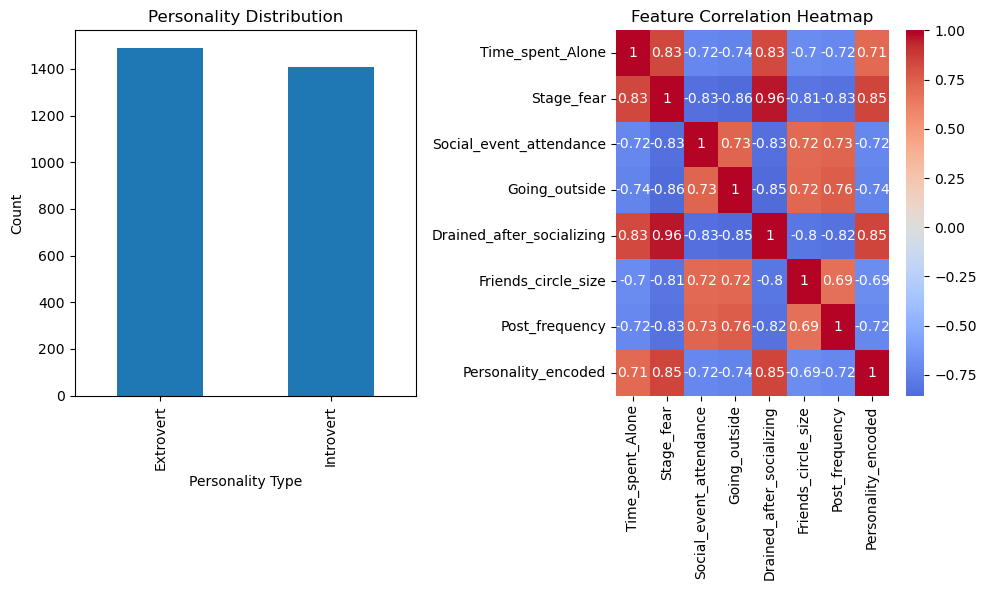

In [25]:
print("\n=== Exploratory Data Analysis ===")

# Plot target distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['Personality'].value_counts().plot(kind='bar')
plt.title('Personality Distribution')
plt.xlabel('Personality Type')
plt.ylabel('Count')

# Correlation heatmap
plt.subplot(1, 2, 2)
numeric_df = df.select_dtypes(include=[np.number])
if 'Personality_encoded' in numeric_df.columns:
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

### Prepare Features and Target

In [26]:
# Select features (exclude target and encoded target)
feature_columns = [col for col in df.columns if col not in ['Personality', 'Personality_encoded']]
X = df[feature_columns]
y = df['Personality_encoded']

print(f"Feature columns: {feature_columns}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Feature columns: ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']
X shape: (2900, 7), y shape: (2900,)


### Split Data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Training target distribution: {pd.Series(y_train).value_counts()}")
print(f"Testing target distribution: {pd.Series(y_test).value_counts()}")

Training set: (2320, 7)
Testing set: (580, 7)
Training target distribution: 0    1193
1    1127
Name: Personality_encoded, dtype: int64
Testing target distribution: 0    298
1    282
Name: Personality_encoded, dtype: int64


### Feature Scaling

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


### Train Models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),  
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

print("\n=== Model Training ===")
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"  Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))



=== Model Training ===
Random Forest:
  Accuracy: 0.9034
  CV Score: 0.9276 (+/- 0.0151)
  Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.91      0.90      0.91       298
   Introvert       0.90      0.90      0.90       282

    accuracy                           0.90       580
   macro avg       0.90      0.90      0.90       580
weighted avg       0.90      0.90      0.90       580

Logistic Regression:
  Accuracy: 0.9069
  CV Score: 0.9310 (+/- 0.0131)
  Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.92      0.90      0.91       298
   Introvert       0.89      0.92      0.91       282

    accuracy                           0.91       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.91      0.91      0.91       580

SVM:
  Accuracy: 0.9172
  CV Score: 0.9388 (+/- 0.0044)
  Classification Report:
              precision    recall  f1-score   support

### Best Model

In [31]:
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\nBest model: {best_model_name} with accuracy: {results[best_model_name]['accuracy']:.4f}")


Best model: SVM with accuracy: 0.9172


### Save Model and Preprocessing Objects

In [33]:
print("\n=== Saving Model ===")
joblib.dump(best_model, 'personality_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(target_encoder, 'target_encoder.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')

print("Model and preprocessing objects saved successfully!")


=== Saving Model ===
Model and preprocessing objects saved successfully!


### Enhanced Prediction

In [34]:
def predict_personality(input_data):
    """
    Predict personality from input data
    Input data should be a dictionary with feature names as keys
    """
    try:
        # Load saved objects
        model = joblib.load('personality_model.pkl')
        scaler = joblib.load('scaler.pkl')
        target_encoder = joblib.load('target_encoder.pkl')
        label_encoders = joblib.load('label_encoders.pkl')
        feature_columns = joblib.load('feature_columns.pkl')
        
        # Create DataFrame from input
        input_df = pd.DataFrame([input_data])
        
        # Preprocess categorical variables
        for col in input_df.columns:
            if col in label_encoders:
                try:
                    input_df[col] = label_encoders[col].transform(input_df[col])
                except ValueError as e:
                    # Handle unseen labels by using the most common class
                    print(f"Warning: Unknown category '{input_df[col].iloc[0]}' in {col}. Using default value.")
                    input_df[col] = 0  # Use first encoded value as default
        
        # Ensure all feature columns are present
        for col in feature_columns:
            if col not in input_df.columns:
                input_df[col] = 0  
        
        # Reorder columns to match training
        input_df = input_df[feature_columns]
        
        # Scale features
        input_scaled = scaler.transform(input_df)
        
        # Predict
        prediction = model.predict(input_scaled)[0]
        
        # Get probabilities (with error handling)
        try:
            prediction_proba = model.predict_proba(input_scaled)[0]
            prob_dict = {
                target_encoder.inverse_transform([i])[0]: float(prob) 
                for i, prob in enumerate(prediction_proba)
            }
        except AttributeError:
            # If model doesn't support predict_proba, create dummy probabilities
            print("Warning: Model doesn't support probability predictions")
            classes = target_encoder.classes_
            prob_dict = {cls: 1.0 if i == prediction else 0.0 for i, cls in enumerate(classes)}
        
        # Convert back to original label
        personality = target_encoder.inverse_transform([prediction])[0]
        
        return personality, prob_dict
    
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, {}

# Test the function
print("\n=== Testing Prediction Function ===")
test_input = {
    'Time_spent_Alone': 4,
    'Stage_fear': 'No',
    'Social_event_attendance': 4,
    'Going_outside': 6,
    'Drained_after_socializing': 'No',
    'Friends_circle_size': 13,
    'Post_frequency': 5
}

prediction, probabilities = predict_personality(test_input)
print(f"Test Prediction: {prediction}")
print(f"Probabilities: {probabilities}")


=== Testing Prediction Function ===
Test Prediction: Extrovert
Probabilities: {'Extrovert': 0.9439296415486286, 'Introvert': 0.05607035845137131}


### Test with examples

In [35]:
print("\n=== Testing Multiple Examples ===")
test_cases = [
    {
        'Time_spent_Alone': 9,
        'Stage_fear': 'Yes',
        'Social_event_attendance': 1,
        'Going_outside': 2,
        'Drained_after_socializing': 'Yes',
        'Friends_circle_size': 5,
        'Post_frequency': 2
    },
    {
        'Time_spent_Alone': 0,
        'Stage_fear': 'No', 
        'Social_event_attendance': 6,
        'Going_outside': 7,
        'Drained_after_socializing': 'No',
        'Friends_circle_size': 14,
        'Post_frequency': 8
    }
]

for i, test_case in enumerate(test_cases):
    pred, probs = predict_personality(test_case)
    print(f"Test Case {i+1}: {pred}")
    print(f"  Probabilities: {probs}")


=== Testing Multiple Examples ===
Test Case 1: Introvert
  Probabilities: {'Extrovert': 0.07028214878471237, 'Introvert': 0.9297178512152876}
Test Case 2: Extrovert
  Probabilities: {'Extrovert': 0.9410771913489476, 'Introvert': 0.058922808651052455}
